In [36]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from bayes_opt import BayesianOptimization

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

import logging
import sys

import joblib


In [2]:
# Configurar logging para LightGBM
sys.stdout = open('lightgbm_output.txt', 'w')
sys.stderr = open('lightgbm_output.txt', 'a')

In [3]:
logging.basicConfig(filename='lgbm_model.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s', filemode='w')


In [4]:
logging.info("Cargando datos...")
df = pd.read_parquet('data/combined_timeseries_interpolated.parquet')

In [5]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df = df.drop(columns=['date'])

In [6]:
X = df.drop(columns=['score_final_interpolated'])
y = df['score_final_interpolated']

In [7]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

logging.info("División temporal de datos en entrenamiento (70%) y prueba (30%) completada.")

## Optimizar la métrica que quieras, pero average = weighted. no como el primer intento que hice.

In [8]:
# Definir la función para la optimización bayesiana
def bayesian_opt_lgbm(X, y, init_iter=5, n_iters=10, random_state=666, seed=101, num_iterations=200):
    tscv = TimeSeriesSplit(n_splits=5)  # Definir TimeSeriesSplit
    dtrain = lgb.Dataset(data=X, label=y)

    # Ajustar para clasificación multiclase con roc_auc_score
    def lgb_roc_auc_score(preds, dtrain):
        labels = dtrain.get_label()
        score = roc_auc_score(labels, preds, multi_class='ovr')
        return 'custom_auc', score, True  # Nombre de la métrica cambiado a 'custom_auc'

    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
        logging.info(f"Probando parámetros: num_leaves={num_leaves}, feature_fraction={feature_fraction}, bagging_fraction={bagging_fraction}, max_depth={max_depth}")
        
        params = {
            'objective': 'multiclass',  # Ajustar a multiclass
            'num_class': len(np.unique(y)),  # Número de clases
            'num_iterations': num_iterations,
            'learning_rate': 0.05,
            'early_stopping_round': 50,
            'metric': 'None',  # No usar métrica predeterminada
        }
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight

        # Usamos feval para definir la métrica personalizada
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed, stratified=False,
                            feval=lgb_roc_auc_score, folds=tscv, shuffle=False)

        # Verificar las claves disponibles en cv_results y escribirlas en el log
        logging.info(f"Resultados de cv: {cv_results.keys()}")

        # Ajustar a la métrica correcta
        score = np.max(cv_results['valid custom_auc-mean'])  # Acceder a la métrica correcta
        logging.info(f"Parámetros evaluados con AUC promedio: {score}")
        
        return score

    pds = {
        'num_leaves': (80, 100),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (17, 25),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (10, 25)
    }

    logging.info("Iniciando optimización bayesiana...")
    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    logging.info("Optimización bayesiana completada.")

    return optimizer


In [9]:
# Ejecutar la optimización bayesiana con TimeSeriesSplit
opt_result = bayesian_opt_lgbm(X_train, y_train, init_iter=5, n_iters=10, random_state=77, seed=101, num_iterations=200)

In [16]:
# Entrenar el mejor modelo encontrado
best_params = opt_result.max['params']
best_params['num_leaves'] = int(round(best_params['num_leaves']))
best_params['max_depth'] = int(round(best_params['max_depth']))
best_params['objective'] = 'multiclass'
best_params['num_class'] = len(np.unique(y_train))  # Número de clases
best_params['metric'] = 'auc'

logging.info(f"Mejores parámetros encontrados: {best_params}")

In [17]:
# Verificar la distribución de clases en el conjunto de entrenamiento
y_train.value_counts()


score_final_interpolated
0.0    706209
1.0    201630
2.0    113638
3.0     69040
4.0     42198
5.0     18085
Name: count, dtype: int64

In [23]:
best_params

{'bagging_fraction': 0.9838218063598364,
 'feature_fraction': 0.6137564799390843,
 'max_depth': 23,
 'min_child_weight': 12.089718521541025,
 'min_split_gain': 0.009644635250970406,
 'num_leaves': 96,
 'objective': 'multiclass',
 'num_class': 6,
 'metric': 'auc'}

In [25]:
best_params['metric'] = 'multi_logloss'

In [26]:
lgbm_best = lgb.LGBMClassifier(
    **best_params,
    class_weight='balanced'  # Para manejar el desbalance
)
lgbm_best.fit(X_train, y_train)
logging.info("Entrenamiento del modelo completado.")

In [27]:
# Predecir en el conjunto de prueba
y_pred = lgbm_best.predict(X_test)
y_prob = lgbm_best.predict_proba(X_test)[:, 1]


In [28]:
# Mostrar métricas de clasificación
print(classification_report(y_test, y_pred))

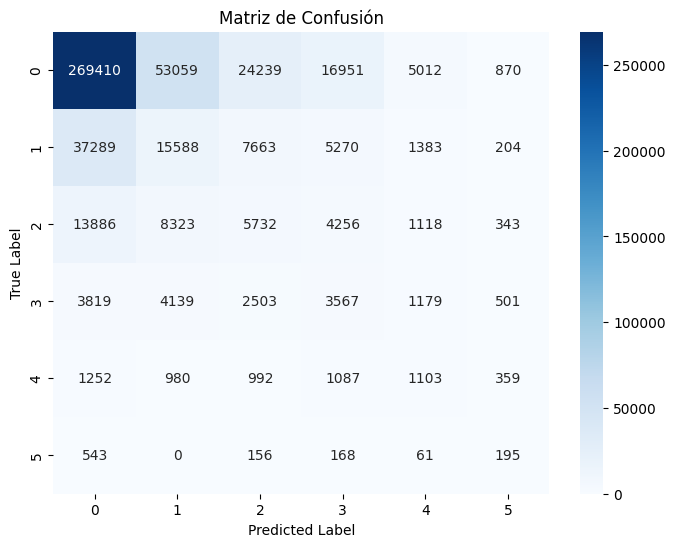

In [29]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [34]:
y_prob = lgbm_best.predict_proba(X_test)

# Verificar la forma de y_prob
y_prob.shape

(493200, 6)

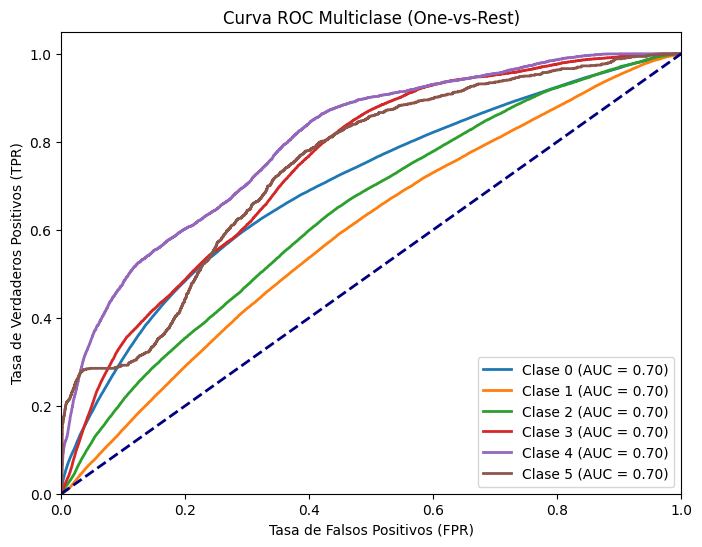

In [35]:
# Binarizar las etiquetas para calcular la curva ROC multiclase (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0])

# Verificar las dimensiones
print("Dimensiones de y_test_bin:", y_test_bin.shape)
print("Dimensiones de y_prob:", y_prob.shape)

# Asegurarnos de que ambas matrices tengan las mismas dimensiones
if y_test_bin.shape != y_prob.shape:
    raise ValueError(f"Dimensiones incompatibles: y_test_bin={y_test_bin.shape}, y_prob={y_prob.shape}")

# Calcular el ROC AUC para multiclase (one-vs-rest)
roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

# Crear una curva ROC para cada clase
fpr = {}
tpr = {}
for i in range(len(np.unique(y_train))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_train))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Clase {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC Multiclase (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

In [37]:
# Guardar el modelo completo en un archivo binario
joblib.dump(lgbm_best, 'lightgbm_model.pkl')
logging.info("Modelo guardado en 'lightgbm_model.pkl'.")